In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse 

In [2]:
def design_mat_pol(x, p):
    n = len(x)
    phi_mat = np.ones((n, 1))
    for i in range(1, p + 1):
        phi_i = (x ** i).reshape(-1, 1)
        phi_mat = np.hstack((phi_mat, phi_i))
    return phi_mat

In [3]:
def design_mat_pwc(x, k):
    x_min = np.min(x)
    x_max = np.max(x)
    n = len(x)
    phi_mat = np.ones((n, 1))
    for i in range(1, k + 1):
        t = x_min + i * (x_max - x_min) / (k + 1)
        phi_i = (x > t)
        phi_mat = np.hstack((phi_mat, phi_i.reshape(-1, 1)))
    return phi_mat

In [4]:
def design_mat_pwl(x, k):
    x_min = np.min(x)
    x_max = np.max(x)
    n = len(x)
    phi_mat = np.hstack((np.ones((n, 1)), x.reshape(-1, 1)))
    for i in range(1, k + 1):
        t = x_min + i * (x_max - x_min) / (k + 1)
        phi_i = (x - t) * (x > t)
        phi_mat = np.hstack((phi_mat, phi_i.reshape(-1, 1)))
    return phi_mat

In [5]:
def np_predict(xmat, y):
    bhat = np.linalg.inv(xmat.T @ xmat) @ xmat.T @ y
    yhat = xmat @ bhat
    return yhat

In [6]:
def skl_predict(xmat, y):
    lr = LinearRegression(fit_intercept=False)
    lr.fit(xmat, y)
    yhat = lr.predict(xmat)
    print('Rank:{}/{}'.format(lr.rank_, xmat.shape[1]))
    return yhat

In [7]:
def np_predict_new(phi_mat, y, phi_mat_new):
    b_hat = np.linalg.inv(phi_mat.T @ phi_mat) @ phi_mat.T @ y
    y_hat = phi_mat_new @ b_hat
    return y_hat

In [8]:
def skl_predict_new(phi_mat, y, phi_mat_new):
    lr = LinearRegression(fit_intercept=False)
    lr.fit(phi_mat, y)
    y_hat = lr.predict(phi_mat_new)
    return y_hat

In [9]:
# Read temperature data from file
data = pd.read_csv('surf_temp.csv')
data

,temp,year,month
0,11.50,1940,1
1,11.87,1940,2
2,12.52,1940,3
3,13.76,1940,4
4,14.75,1940,5
...,...,...,...
1012,15.91,2024,5
1013,16.66,2024,6
1014,16.91,2024,7
1015,16.82,2024,8


In [10]:
# Create a matrix of indicators
umat = pd.get_dummies(data['month'], drop_first=True, dtype=int).values
umat

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Rank:16/16


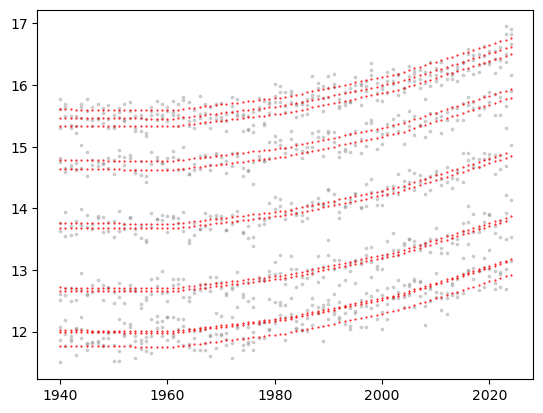

In [11]:
y = data['temp'].values
x = data['year'].values

# You may want to re-scale x for polynomial basis
# x = (data['year'].values - 1940) / 84
     
phimat = design_mat_pwl(x, 3)
xmat = np.hstack((phimat, umat))
yhat = skl_predict(xmat, y)
plt.scatter(x, y, color='grey', s=3, alpha=0.3)
plt.plot(x, yhat, 'r.', markersize=1.0)
plt.show()

In [12]:
# Train-validation-test split (updated!)
y = data['temp'].to_numpy(dtype=float)
x = data[['year', 'month']].to_numpy(dtype=float)

# Re-scale 'year' column if needed
x[:, 0] = (x[:, 0] - 1940) / 84

x_tv, x_test, y_tv, y_test = train_test_split(
    x, y, test_size=1/4, random_state=1)
x_train, x_vali, y_train, y_vali = train_test_split(
    x_tv, y_tv, test_size=1/3, random_state=1)

In [13]:
p = np.arange(1, 11)
p

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [17]:
# Updated!
umat = pd.get_dummies(x_train[:, 1], drop_first=True, dtype=int).values
umat_new = pd.get_dummies(x_vali[:, 1], drop_first=True, dtype=int).values

n_p = len(p)
mse_vali = np.empty(n_p)
for i in range(n_p):
    phimat = design_mat_pwl(x_train[:, 0], p[i])
    phimat_new = design_mat_pwl(x_vali[:, 0], p[i])
    xmat = np.hstack((phimat, umat))
    xmat_new = np.hstack((phimat_new, umat_new))
    yhat = skl_predict_new(xmat, y_train, xmat_new)
    mse_vali[i] = mse(y_vali, yhat)

In [18]:
mse_vali

array([0.02199306, 0.02067222, 0.02165389, 0.02119438, 0.02154077,
       0.02104248, 0.02011698, 0.02054361, 0.02100394, 0.02174609])

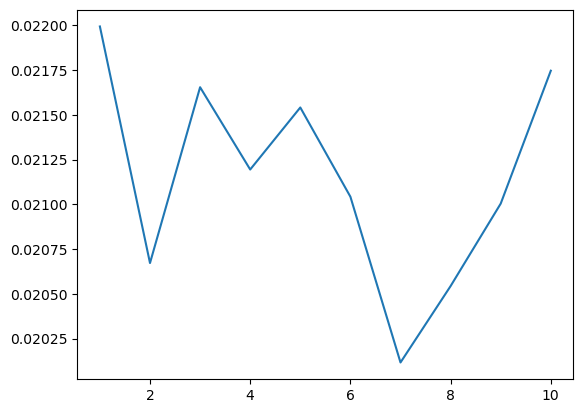

In [19]:
plt.plot(p, mse_vali)
plt.show()

In [20]:
np.argmin(mse_vali)

6